# info

##### モデリング
- モデルの出力値を適切に加工している

##### 発展
- 非線形モデルを使用し、ハイパーパラメーターチューニングを行っている
- 自身が生成したモデルを用いてアンサンブルに予測し、精度を確認している

# init

In [1]:
import os, copy, uuid
import numpy as np
import pandas as pd

import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.externals import joblib

C:\Users\keisu\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning:

numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.



# load

In [2]:
path_doc = "../doc/"

In [3]:
path_data = "../data/"
path_clns = path_data + "clns/"

In [4]:
_dic_data = dict()
for d in os.listdir(path_clns):
    fn = d.split(".")[0]
    _dic_data[fn] = pd.read_csv(path_clns+d, index_col=0)

In [5]:
def get_mart():
    dic_data = copy.deepcopy(_dic_data)
    yname = "survived"
    y = dic_data["y"]
    test_id = y[y[yname].isna()].index
    
    nums = [dic_data["num_logz"], 
#             dic_data["num_proba"]
           ]
    cats = list()

    onehot = [v for k, v in dic_data.items() if ("onehot" in k) and not ("family" in k or "parch_sibsp" in k)]
    onehot_fam = [v for k, v in dic_data.items() if ("onehot" in k) and ("family" in k)]
    onehot_ps = [v for k, v in dic_data.items() if ("onehot" in k) and ("parch_sibsp" in k)]
    
    tgtenc = [v for k, v in dic_data.items() if ("tgt" in k) and not ("family" in k or "parch_sibsp" in k)]
    tgt_fam = [v for k, v in dic_data.items() if ("tgt" in k) and ("family" in k)]
    tgt_ps = [v for k, v in dic_data.items() if ("tgt" in k) and ("parch_sibsp" in k)]

    cats += onehot
    cats += tgtenc
    cats += onehot_fam
    cats += onehot_ps
    cats += tgt_fam
    cats += tgt_ps
            
    mart = pd.concat([y, *nums, *cats], axis=1)
    train, test = mart[~mart.index.isin(test_id)], mart[mart.index.isin(test_id)]
    train_X, train_y, test_X = train.drop(yname, 1), train[yname], test.drop(yname, 1)
    return train_X, train_y, test_X

In [6]:
train_X, train_y, test_X = get_mart()

In [7]:
train_X.T

id,3,4,7,9,11,13,16,19,23,24,...,867,868,869,871,872,873,874,879,884,888
age,0.473845,0.473845,-3.561376,-0.947822,1.276078,0.644939,-3.561376,0.215183,0.122722,-1.777348,...,0.282578,0.215183,-2.731851,0.941009,0.381026,0.941009,0.122722,1.220076,-0.054606,0.215183
fare,1.061442,-0.783739,0.136423,0.489163,0.365056,0.528402,0.457263,-0.882379,0.655351,0.136423,...,1.010532,-0.630382,-0.481186,1.050978,-1.207872,-0.680730,0.264827,1.517421,-0.904572,0.241871
isna_age,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
iszero_fare,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
embarked_QorS,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000
pclass_2nd,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
pclass_3rd,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,...,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000
sex_male,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,...,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
is_child,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
is_1st_male,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [8]:
test_X.T

id,0,1,2,5,6,8,10,12,14,15,...,878,880,881,882,883,885,886,887,889,890
age,-0.253699,0.603825,0.006680,0.215183,1.162074,0.065737,-2.731851,-0.401428,-0.947822,1.191334,...,0.215183,-0.054606,0.381026,-0.253699,0.122722,0.644939,0.065737,-0.480658,0.006680,0.332548
fare,-0.879247,1.360456,-0.798092,-0.738202,1.037563,-0.481186,-0.091514,-0.783739,-0.806311,-0.133154,...,-0.801473,0.344246,-0.801473,-0.535007,-0.536504,0.457263,-0.333511,0.486809,0.486809,-0.818527
isna_age,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
iszero_fare,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
embarked_QorS,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000
pclass_2nd,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000
pclass_3rd,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,...,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
sex_male,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000
is_child,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
is_1st_male,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000


In [9]:
train_y.to_frame().T

id,3,4,7,9,11,13,16,19,23,24,...,867,868,869,871,872,873,874,879,884,888
survived,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0


# clns

- 決定木系のアルゴリズムはonehotにすると処理効率が悪くなるため、family-size, parch, sibspをlabel encodingに変更

In [10]:
def clns_family(df):
    df = df.copy()

    fsize = df.filter(regex="family-size_[0-9]")
    df = df.drop(fsize, 1)
    fsize = fsize.dot([1,2,3,4,5,6,7,10])

    parch = df.filter(regex="parch_[0-9]")
    df = df.drop(parch, 1)
    parch = parch.dot([1,2,3,4])

    sibsp = df.filter(regex="sibsp_[0-9]")
    df = df.drop(sibsp, 1)
    sibsp = sibsp.dot([1,2,3,4])

    df["family-size"] = fsize
    df["parch"] = parch
    df["sibsp"] = sibsp
    
    return df

In [11]:
train_X = clns_family(train_X)
test_X = clns_family(test_X)

# modeling --RandomForest--

- まずはn_estimator以外のパラメーターをチューニングし、最終的に大きなn_estimatorでモデリングする。

In [12]:
def objective(trial):
    kf = StratifiedKFold(n_splits=5, shuffle=True)
    params = {
        "n_estimators":100,
        "max_depth":int(trial.suggest_int('max_depth', 2, 20)),
        "min_samples_split":trial.suggest_uniform('min_samples_split', 0, 0.5),
        "min_weight_fraction_leaf":trial.suggest_uniform('min_weight_fraction_leaf', 0, 0.5),
        "max_features":trial.suggest_uniform('max_features', 0.3, 1),
        "class_weight":trial.suggest_categorical('class_weight', ['balanced', 'balanced_subsample', None]),
        "n_jobs":-1,
        "random_state":1234
    }
    clf = RandomForestClassifier(**params)
    scores = cross_validate(clf, scoring="roc_auc", X=train_X, y=train_y, cv=kf)
    auc = scores['test_score'].mean()
    return auc

In [13]:
study = optuna.create_study(direction='maximize')

In [14]:
study.optimize(objective, n_trials=2**8)

[I 2020-04-22 23:34:37,725] Finished trial#0 resulted in value: 0.8342685212915821. Current best value is 0.8342685212915821 with parameters: {'max_depth': 4, 'min_samples_split': 0.4731984131367684, 'min_weight_fraction_leaf': 0.25899320826297284, 'max_features': 0.4761443326187775, 'class_weight': 'balanced_subsample'}.
[I 2020-04-22 23:34:40,505] Finished trial#1 resulted in value: 0.8397876942531031. Current best value is 0.8397876942531031 with parameters: {'max_depth': 10, 'min_samples_split': 0.4491175324822833, 'min_weight_fraction_leaf': 0.14235214094315252, 'max_features': 0.6979323629881704, 'class_weight': None}.
[I 2020-04-22 23:34:43,507] Finished trial#2 resulted in value: 0.8404090268765321. Current best value is 0.8404090268765321 with parameters: {'max_depth': 5, 'min_samples_split': 0.393637119354931, 'min_weight_fraction_leaf': 0.23319554945165505, 'max_features': 0.5102449188843481, 'class_weight': None}.
[I 2020-04-22 23:34:46,193] Finished trial#3 resulted in val

[I 2020-04-22 23:35:51,406] Finished trial#25 resulted in value: 0.8399184996616864. Current best value is 0.8667842722926581 with parameters: {'max_depth': 8, 'min_samples_split': 0.002334512921780562, 'min_weight_fraction_leaf': 0.016508235464832124, 'max_features': 0.8645034910364348, 'class_weight': 'balanced'}.
[I 2020-04-22 23:35:54,212] Finished trial#26 resulted in value: 0.8299584872383615. Current best value is 0.8667842722926581 with parameters: {'max_depth': 8, 'min_samples_split': 0.002334512921780562, 'min_weight_fraction_leaf': 0.016508235464832124, 'max_features': 0.8645034910364348, 'class_weight': 'balanced'}.
[I 2020-04-22 23:35:56,956] Finished trial#27 resulted in value: 0.8176631393298062. Current best value is 0.8667842722926581 with parameters: {'max_depth': 8, 'min_samples_split': 0.002334512921780562, 'min_weight_fraction_leaf': 0.016508235464832124, 'max_features': 0.8645034910364348, 'class_weight': 'balanced'}.
[I 2020-04-22 23:35:59,745] Finished trial#28 

[I 2020-04-22 23:37:02,069] Finished trial#50 resulted in value: 0.8671675096779918. Current best value is 0.8671675096779918 with parameters: {'max_depth': 17, 'min_samples_split': 0.0005458082360434563, 'min_weight_fraction_leaf': 0.011648759380910144, 'max_features': 0.8241457996262099, 'class_weight': 'balanced'}.
[I 2020-04-22 23:37:05,286] Finished trial#51 resulted in value: 0.8360613623506706. Current best value is 0.8671675096779918 with parameters: {'max_depth': 17, 'min_samples_split': 0.0005458082360434563, 'min_weight_fraction_leaf': 0.011648759380910144, 'max_features': 0.8241457996262099, 'class_weight': 'balanced'}.
[I 2020-04-22 23:37:07,951] Finished trial#52 resulted in value: 0.8165503366499174. Current best value is 0.8671675096779918 with parameters: {'max_depth': 17, 'min_samples_split': 0.0005458082360434563, 'min_weight_fraction_leaf': 0.011648759380910144, 'max_features': 0.8241457996262099, 'class_weight': 'balanced'}.
[I 2020-04-22 23:37:10,616] Finished tri

[I 2020-04-22 23:38:10,913] Finished trial#75 resulted in value: 0.8410224008075161. Current best value is 0.8671675096779918 with parameters: {'max_depth': 17, 'min_samples_split': 0.0005458082360434563, 'min_weight_fraction_leaf': 0.011648759380910144, 'max_features': 0.8241457996262099, 'class_weight': 'balanced'}.
[I 2020-04-22 23:38:13,702] Finished trial#76 resulted in value: 0.8486421416924561. Current best value is 0.8671675096779918 with parameters: {'max_depth': 17, 'min_samples_split': 0.0005458082360434563, 'min_weight_fraction_leaf': 0.011648759380910144, 'max_features': 0.8241457996262099, 'class_weight': 'balanced'}.
[I 2020-04-22 23:38:16,412] Finished trial#77 resulted in value: 0.8481764888578306. Current best value is 0.8671675096779918 with parameters: {'max_depth': 17, 'min_samples_split': 0.0005458082360434563, 'min_weight_fraction_leaf': 0.011648759380910144, 'max_features': 0.8241457996262099, 'class_weight': 'balanced'}.
[I 2020-04-22 23:38:19,111] Finished tri

[I 2020-04-22 23:39:23,533] Finished trial#100 resulted in value: 0.8414558583740973. Current best value is 0.8671675096779918 with parameters: {'max_depth': 17, 'min_samples_split': 0.0005458082360434563, 'min_weight_fraction_leaf': 0.011648759380910144, 'max_features': 0.8241457996262099, 'class_weight': 'balanced'}.
[I 2020-04-22 23:39:26,388] Finished trial#101 resulted in value: 0.8547611005734697. Current best value is 0.8671675096779918 with parameters: {'max_depth': 17, 'min_samples_split': 0.0005458082360434563, 'min_weight_fraction_leaf': 0.011648759380910144, 'max_features': 0.8241457996262099, 'class_weight': 'balanced'}.
[I 2020-04-22 23:39:29,490] Finished trial#102 resulted in value: 0.8459581211939702. Current best value is 0.8671675096779918 with parameters: {'max_depth': 17, 'min_samples_split': 0.0005458082360434563, 'min_weight_fraction_leaf': 0.011648759380910144, 'max_features': 0.8241457996262099, 'class_weight': 'balanced'}.
[I 2020-04-22 23:39:32,573] Finished 

[I 2020-04-22 23:40:34,834] Finished trial#125 resulted in value: 0.8383843577030159. Current best value is 0.8671675096779918 with parameters: {'max_depth': 17, 'min_samples_split': 0.0005458082360434563, 'min_weight_fraction_leaf': 0.011648759380910144, 'max_features': 0.8241457996262099, 'class_weight': 'balanced'}.
[I 2020-04-22 23:40:37,880] Finished trial#126 resulted in value: 0.8600077645779951. Current best value is 0.8671675096779918 with parameters: {'max_depth': 17, 'min_samples_split': 0.0005458082360434563, 'min_weight_fraction_leaf': 0.011648759380910144, 'max_features': 0.8241457996262099, 'class_weight': 'balanced'}.
[I 2020-04-22 23:40:40,624] Finished trial#127 resulted in value: 0.8308106219426973. Current best value is 0.8671675096779918 with parameters: {'max_depth': 17, 'min_samples_split': 0.0005458082360434563, 'min_weight_fraction_leaf': 0.011648759380910144, 'max_features': 0.8241457996262099, 'class_weight': 'balanced'}.
[I 2020-04-22 23:40:43,299] Finished 

[I 2020-04-22 23:41:44,726] Finished trial#150 resulted in value: 0.8606864164254102. Current best value is 0.8671675096779918 with parameters: {'max_depth': 17, 'min_samples_split': 0.0005458082360434563, 'min_weight_fraction_leaf': 0.011648759380910144, 'max_features': 0.8241457996262099, 'class_weight': 'balanced'}.
[I 2020-04-22 23:41:47,416] Finished trial#151 resulted in value: 0.8668390680287956. Current best value is 0.8671675096779918 with parameters: {'max_depth': 17, 'min_samples_split': 0.0005458082360434563, 'min_weight_fraction_leaf': 0.011648759380910144, 'max_features': 0.8241457996262099, 'class_weight': 'balanced'}.
[I 2020-04-22 23:41:50,149] Finished trial#152 resulted in value: 0.8377580058345255. Current best value is 0.8671675096779918 with parameters: {'max_depth': 17, 'min_samples_split': 0.0005458082360434563, 'min_weight_fraction_leaf': 0.011648759380910144, 'max_features': 0.8241457996262099, 'class_weight': 'balanced'}.
[I 2020-04-22 23:41:52,850] Finished 

[I 2020-04-22 23:42:53,276] Finished trial#175 resulted in value: 0.8576455026455028. Current best value is 0.8674081006732999 with parameters: {'max_depth': 19, 'min_samples_split': 0.10577088129547736, 'min_weight_fraction_leaf': 0.02980790736553154, 'max_features': 0.9120621320745796, 'class_weight': 'balanced'}.
[I 2020-04-22 23:42:56,127] Finished trial#176 resulted in value: 0.8348254911095582. Current best value is 0.8674081006732999 with parameters: {'max_depth': 19, 'min_samples_split': 0.10577088129547736, 'min_weight_fraction_leaf': 0.02980790736553154, 'max_features': 0.9120621320745796, 'class_weight': 'balanced'}.
[I 2020-04-22 23:42:59,365] Finished trial#177 resulted in value: 0.8436879804332633. Current best value is 0.8674081006732999 with parameters: {'max_depth': 19, 'min_samples_split': 0.10577088129547736, 'min_weight_fraction_leaf': 0.02980790736553154, 'max_features': 0.9120621320745796, 'class_weight': 'balanced'}.
[I 2020-04-22 23:43:02,347] Finished trial#178

[I 2020-04-22 23:44:03,623] Finished trial#200 resulted in value: 0.8435375694652425. Current best value is 0.8674081006732999 with parameters: {'max_depth': 19, 'min_samples_split': 0.10577088129547736, 'min_weight_fraction_leaf': 0.02980790736553154, 'max_features': 0.9120621320745796, 'class_weight': 'balanced'}.
[I 2020-04-22 23:44:06,376] Finished trial#201 resulted in value: 0.8398610140538862. Current best value is 0.8674081006732999 with parameters: {'max_depth': 19, 'min_samples_split': 0.10577088129547736, 'min_weight_fraction_leaf': 0.02980790736553154, 'max_features': 0.9120621320745796, 'class_weight': 'balanced'}.
[I 2020-04-22 23:44:09,105] Finished trial#202 resulted in value: 0.8504449935110312. Current best value is 0.8674081006732999 with parameters: {'max_depth': 19, 'min_samples_split': 0.10577088129547736, 'min_weight_fraction_leaf': 0.02980790736553154, 'max_features': 0.9120621320745796, 'class_weight': 'balanced'}.
[I 2020-04-22 23:44:11,812] Finished trial#203

[I 2020-04-22 23:45:13,750] Finished trial#225 resulted in value: 0.8535307754594967. Current best value is 0.8674081006732999 with parameters: {'max_depth': 19, 'min_samples_split': 0.10577088129547736, 'min_weight_fraction_leaf': 0.02980790736553154, 'max_features': 0.9120621320745796, 'class_weight': 'balanced'}.
[I 2020-04-22 23:45:16,533] Finished trial#226 resulted in value: 0.802186255587723. Current best value is 0.8674081006732999 with parameters: {'max_depth': 19, 'min_samples_split': 0.10577088129547736, 'min_weight_fraction_leaf': 0.02980790736553154, 'max_features': 0.9120621320745796, 'class_weight': 'balanced'}.
[I 2020-04-22 23:45:19,241] Finished trial#227 resulted in value: 0.845372145131055. Current best value is 0.8674081006732999 with parameters: {'max_depth': 19, 'min_samples_split': 0.10577088129547736, 'min_weight_fraction_leaf': 0.02980790736553154, 'max_features': 0.9120621320745796, 'class_weight': 'balanced'}.
[I 2020-04-22 23:45:22,034] Finished trial#228 r

[I 2020-04-22 23:46:23,980] Finished trial#250 resulted in value: 0.8537960189899394. Current best value is 0.8683418466384923 with parameters: {'max_depth': 7, 'min_samples_split': 0.05964131281685964, 'min_weight_fraction_leaf': 0.028815672527307448, 'max_features': 0.7753452255830102, 'class_weight': 'balanced'}.
[I 2020-04-22 23:46:26,841] Finished trial#251 resulted in value: 0.8548073552738125. Current best value is 0.8683418466384923 with parameters: {'max_depth': 7, 'min_samples_split': 0.05964131281685964, 'min_weight_fraction_leaf': 0.028815672527307448, 'max_features': 0.7753452255830102, 'class_weight': 'balanced'}.
[I 2020-04-22 23:46:29,816] Finished trial#252 resulted in value: 0.8344702062050071. Current best value is 0.8683418466384923 with parameters: {'max_depth': 7, 'min_samples_split': 0.05964131281685964, 'min_weight_fraction_leaf': 0.028815672527307448, 'max_features': 0.7753452255830102, 'class_weight': 'balanced'}.
[I 2020-04-22 23:46:32,574] Finished trial#253

In [15]:
study.optimize(objective, n_trials=2**8)

[I 2020-04-22 23:46:41,300] Finished trial#256 resulted in value: 0.8318283085421448. Current best value is 0.8683418466384923 with parameters: {'max_depth': 7, 'min_samples_split': 0.05964131281685964, 'min_weight_fraction_leaf': 0.028815672527307448, 'max_features': 0.7753452255830102, 'class_weight': 'balanced'}.
[I 2020-04-22 23:46:44,061] Finished trial#257 resulted in value: 0.8552795802690982. Current best value is 0.8683418466384923 with parameters: {'max_depth': 7, 'min_samples_split': 0.05964131281685964, 'min_weight_fraction_leaf': 0.028815672527307448, 'max_features': 0.7753452255830102, 'class_weight': 'balanced'}.
[I 2020-04-22 23:46:46,855] Finished trial#258 resulted in value: 0.8516526904262754. Current best value is 0.8683418466384923 with parameters: {'max_depth': 7, 'min_samples_split': 0.05964131281685964, 'min_weight_fraction_leaf': 0.028815672527307448, 'max_features': 0.7753452255830102, 'class_weight': 'balanced'}.
[I 2020-04-22 23:46:49,584] Finished trial#259

[I 2020-04-22 23:47:51,805] Finished trial#281 resulted in value: 0.8538368107550497. Current best value is 0.8749028873137888 with parameters: {'max_depth': 7, 'min_samples_split': 0.0340133024192872, 'min_weight_fraction_leaf': 0.006747087644722276, 'max_features': 0.8888512854733372, 'class_weight': 'balanced'}.
[I 2020-04-22 23:47:54,567] Finished trial#282 resulted in value: 0.8063850620611628. Current best value is 0.8749028873137888 with parameters: {'max_depth': 7, 'min_samples_split': 0.0340133024192872, 'min_weight_fraction_leaf': 0.006747087644722276, 'max_features': 0.8888512854733372, 'class_weight': 'balanced'}.
[I 2020-04-22 23:47:57,440] Finished trial#283 resulted in value: 0.8606498951781971. Current best value is 0.8749028873137888 with parameters: {'max_depth': 7, 'min_samples_split': 0.0340133024192872, 'min_weight_fraction_leaf': 0.006747087644722276, 'max_features': 0.8888512854733372, 'class_weight': 'balanced'}.
[I 2020-04-22 23:48:00,682] Finished trial#284 re

[I 2020-04-22 23:49:03,684] Finished trial#306 resulted in value: 0.8537395594156599. Current best value is 0.8749028873137888 with parameters: {'max_depth': 7, 'min_samples_split': 0.0340133024192872, 'min_weight_fraction_leaf': 0.006747087644722276, 'max_features': 0.8888512854733372, 'class_weight': 'balanced'}.
[I 2020-04-22 23:49:06,533] Finished trial#307 resulted in value: 0.8569481880802636. Current best value is 0.8749028873137888 with parameters: {'max_depth': 7, 'min_samples_split': 0.0340133024192872, 'min_weight_fraction_leaf': 0.006747087644722276, 'max_features': 0.8888512854733372, 'class_weight': 'balanced'}.
[I 2020-04-22 23:49:09,280] Finished trial#308 resulted in value: 0.8588777689039745. Current best value is 0.8749028873137888 with parameters: {'max_depth': 7, 'min_samples_split': 0.0340133024192872, 'min_weight_fraction_leaf': 0.006747087644722276, 'max_features': 0.8888512854733372, 'class_weight': 'balanced'}.
[I 2020-04-22 23:49:12,039] Finished trial#309 re

[I 2020-04-22 23:50:14,607] Finished trial#331 resulted in value: 0.860155069714818. Current best value is 0.8749028873137888 with parameters: {'max_depth': 7, 'min_samples_split': 0.0340133024192872, 'min_weight_fraction_leaf': 0.006747087644722276, 'max_features': 0.8888512854733372, 'class_weight': 'balanced'}.
[I 2020-04-22 23:50:17,350] Finished trial#332 resulted in value: 0.8449381884130311. Current best value is 0.8749028873137888 with parameters: {'max_depth': 7, 'min_samples_split': 0.0340133024192872, 'min_weight_fraction_leaf': 0.006747087644722276, 'max_features': 0.8888512854733372, 'class_weight': 'balanced'}.
[I 2020-04-22 23:50:20,333] Finished trial#333 resulted in value: 0.832543481636773. Current best value is 0.8749028873137888 with parameters: {'max_depth': 7, 'min_samples_split': 0.0340133024192872, 'min_weight_fraction_leaf': 0.006747087644722276, 'max_features': 0.8888512854733372, 'class_weight': 'balanced'}.
[I 2020-04-22 23:50:23,107] Finished trial#334 resu

[I 2020-04-22 23:51:25,632] Finished trial#356 resulted in value: 0.8464907157831686. Current best value is 0.8749028873137888 with parameters: {'max_depth': 7, 'min_samples_split': 0.0340133024192872, 'min_weight_fraction_leaf': 0.006747087644722276, 'max_features': 0.8888512854733372, 'class_weight': 'balanced'}.
[I 2020-04-22 23:51:28,653] Finished trial#357 resulted in value: 0.8565612902510177. Current best value is 0.8749028873137888 with parameters: {'max_depth': 7, 'min_samples_split': 0.0340133024192872, 'min_weight_fraction_leaf': 0.006747087644722276, 'max_features': 0.8888512854733372, 'class_weight': 'balanced'}.
[I 2020-04-22 23:51:31,691] Finished trial#358 resulted in value: 0.8321264683371602. Current best value is 0.8749028873137888 with parameters: {'max_depth': 7, 'min_samples_split': 0.0340133024192872, 'min_weight_fraction_leaf': 0.006747087644722276, 'max_features': 0.8888512854733372, 'class_weight': 'balanced'}.
[I 2020-04-22 23:51:34,641] Finished trial#359 re

[I 2020-04-22 23:52:37,730] Finished trial#381 resulted in value: 0.8640248521957116. Current best value is 0.8749028873137888 with parameters: {'max_depth': 7, 'min_samples_split': 0.0340133024192872, 'min_weight_fraction_leaf': 0.006747087644722276, 'max_features': 0.8888512854733372, 'class_weight': 'balanced'}.
[I 2020-04-22 23:52:40,550] Finished trial#382 resulted in value: 0.8513609641387418. Current best value is 0.8749028873137888 with parameters: {'max_depth': 7, 'min_samples_split': 0.0340133024192872, 'min_weight_fraction_leaf': 0.006747087644722276, 'max_features': 0.8888512854733372, 'class_weight': 'balanced'}.
[I 2020-04-22 23:52:43,370] Finished trial#383 resulted in value: 0.8520295497653988. Current best value is 0.8749028873137888 with parameters: {'max_depth': 7, 'min_samples_split': 0.0340133024192872, 'min_weight_fraction_leaf': 0.006747087644722276, 'max_features': 0.8888512854733372, 'class_weight': 'balanced'}.
[I 2020-04-22 23:52:46,160] Finished trial#384 re

[I 2020-04-22 23:53:49,747] Finished trial#406 resulted in value: 0.854717674397968. Current best value is 0.8749028873137888 with parameters: {'max_depth': 7, 'min_samples_split': 0.0340133024192872, 'min_weight_fraction_leaf': 0.006747087644722276, 'max_features': 0.8888512854733372, 'class_weight': 'balanced'}.
[I 2020-04-22 23:53:52,718] Finished trial#407 resulted in value: 0.8552975219903942. Current best value is 0.8749028873137888 with parameters: {'max_depth': 7, 'min_samples_split': 0.0340133024192872, 'min_weight_fraction_leaf': 0.006747087644722276, 'max_features': 0.8888512854733372, 'class_weight': 'balanced'}.
[I 2020-04-22 23:53:55,515] Finished trial#408 resulted in value: 0.8564905771299902. Current best value is 0.8749028873137888 with parameters: {'max_depth': 7, 'min_samples_split': 0.0340133024192872, 'min_weight_fraction_leaf': 0.006747087644722276, 'max_features': 0.8888512854733372, 'class_weight': 'balanced'}.
[I 2020-04-22 23:53:58,408] Finished trial#409 res

[I 2020-04-22 23:55:02,817] Finished trial#431 resulted in value: 0.8584263973467328. Current best value is 0.8749028873137888 with parameters: {'max_depth': 7, 'min_samples_split': 0.0340133024192872, 'min_weight_fraction_leaf': 0.006747087644722276, 'max_features': 0.8888512854733372, 'class_weight': 'balanced'}.
[I 2020-04-22 23:55:05,714] Finished trial#432 resulted in value: 0.8545591660843233. Current best value is 0.8749028873137888 with parameters: {'max_depth': 7, 'min_samples_split': 0.0340133024192872, 'min_weight_fraction_leaf': 0.006747087644722276, 'max_features': 0.8888512854733372, 'class_weight': 'balanced'}.
[I 2020-04-22 23:55:08,547] Finished trial#433 resulted in value: 0.8504974876044058. Current best value is 0.8749028873137888 with parameters: {'max_depth': 7, 'min_samples_split': 0.0340133024192872, 'min_weight_fraction_leaf': 0.006747087644722276, 'max_features': 0.8888512854733372, 'class_weight': 'balanced'}.
[I 2020-04-22 23:55:11,395] Finished trial#434 re

[I 2020-04-22 23:56:15,096] Finished trial#456 resulted in value: 0.8340358889887192. Current best value is 0.8749028873137888 with parameters: {'max_depth': 7, 'min_samples_split': 0.0340133024192872, 'min_weight_fraction_leaf': 0.006747087644722276, 'max_features': 0.8888512854733372, 'class_weight': 'balanced'}.
[I 2020-04-22 23:56:17,919] Finished trial#457 resulted in value: 0.8365728261954677. Current best value is 0.8749028873137888 with parameters: {'max_depth': 7, 'min_samples_split': 0.0340133024192872, 'min_weight_fraction_leaf': 0.006747087644722276, 'max_features': 0.8888512854733372, 'class_weight': 'balanced'}.
[I 2020-04-22 23:56:20,934] Finished trial#458 resulted in value: 0.8483735704857299. Current best value is 0.8749028873137888 with parameters: {'max_depth': 7, 'min_samples_split': 0.0340133024192872, 'min_weight_fraction_leaf': 0.006747087644722276, 'max_features': 0.8888512854733372, 'class_weight': 'balanced'}.
[I 2020-04-22 23:56:23,865] Finished trial#459 re

[I 2020-04-22 23:57:28,022] Finished trial#481 resulted in value: 0.8335473583796436. Current best value is 0.8749028873137888 with parameters: {'max_depth': 7, 'min_samples_split': 0.0340133024192872, 'min_weight_fraction_leaf': 0.006747087644722276, 'max_features': 0.8888512854733372, 'class_weight': 'balanced'}.
[I 2020-04-22 23:57:30,848] Finished trial#482 resulted in value: 0.8591218262287444. Current best value is 0.8749028873137888 with parameters: {'max_depth': 7, 'min_samples_split': 0.0340133024192872, 'min_weight_fraction_leaf': 0.006747087644722276, 'max_features': 0.8888512854733372, 'class_weight': 'balanced'}.
[I 2020-04-22 23:57:33,647] Finished trial#483 resulted in value: 0.847966623406875. Current best value is 0.8749028873137888 with parameters: {'max_depth': 7, 'min_samples_split': 0.0340133024192872, 'min_weight_fraction_leaf': 0.006747087644722276, 'max_features': 0.8888512854733372, 'class_weight': 'balanced'}.
[I 2020-04-22 23:57:36,602] Finished trial#484 res

[I 2020-04-22 23:58:41,071] Finished trial#506 resulted in value: 0.8366057701906758. Current best value is 0.8749028873137888 with parameters: {'max_depth': 7, 'min_samples_split': 0.0340133024192872, 'min_weight_fraction_leaf': 0.006747087644722276, 'max_features': 0.8888512854733372, 'class_weight': 'balanced'}.
[I 2020-04-22 23:58:43,999] Finished trial#507 resulted in value: 0.8509378223686399. Current best value is 0.8749028873137888 with parameters: {'max_depth': 7, 'min_samples_split': 0.0340133024192872, 'min_weight_fraction_leaf': 0.006747087644722276, 'max_features': 0.8888512854733372, 'class_weight': 'balanced'}.
[I 2020-04-22 23:58:46,893] Finished trial#508 resulted in value: 0.8541023593224851. Current best value is 0.8749028873137888 with parameters: {'max_depth': 7, 'min_samples_split': 0.0340133024192872, 'min_weight_fraction_leaf': 0.006747087644722276, 'max_features': 0.8888512854733372, 'class_weight': 'balanced'}.
[I 2020-04-22 23:58:49,724] Finished trial#509 re

In [16]:
study.optimize(objective, n_trials=2**8)

[I 2020-04-22 23:58:58,533] Finished trial#512 resulted in value: 0.8601572327044025. Current best value is 0.8749028873137888 with parameters: {'max_depth': 7, 'min_samples_split': 0.0340133024192872, 'min_weight_fraction_leaf': 0.006747087644722276, 'max_features': 0.8888512854733372, 'class_weight': 'balanced'}.
[I 2020-04-22 23:59:01,399] Finished trial#513 resulted in value: 0.8555963750513017. Current best value is 0.8749028873137888 with parameters: {'max_depth': 7, 'min_samples_split': 0.0340133024192872, 'min_weight_fraction_leaf': 0.006747087644722276, 'max_features': 0.8888512854733372, 'class_weight': 'balanced'}.
[I 2020-04-22 23:59:04,386] Finished trial#514 resulted in value: 0.8380604638780739. Current best value is 0.8749028873137888 with parameters: {'max_depth': 7, 'min_samples_split': 0.0340133024192872, 'min_weight_fraction_leaf': 0.006747087644722276, 'max_features': 0.8888512854733372, 'class_weight': 'balanced'}.
[I 2020-04-22 23:59:07,349] Finished trial#515 re

[I 2020-04-23 00:00:12,716] Finished trial#537 resulted in value: 0.8478284139185606. Current best value is 0.8749028873137888 with parameters: {'max_depth': 7, 'min_samples_split': 0.0340133024192872, 'min_weight_fraction_leaf': 0.006747087644722276, 'max_features': 0.8888512854733372, 'class_weight': 'balanced'}.
[I 2020-04-23 00:00:15,730] Finished trial#538 resulted in value: 0.8645408361341275. Current best value is 0.8749028873137888 with parameters: {'max_depth': 7, 'min_samples_split': 0.0340133024192872, 'min_weight_fraction_leaf': 0.006747087644722276, 'max_features': 0.8888512854733372, 'class_weight': 'balanced'}.
[I 2020-04-23 00:00:18,560] Finished trial#539 resulted in value: 0.8517824420707021. Current best value is 0.8749028873137888 with parameters: {'max_depth': 7, 'min_samples_split': 0.0340133024192872, 'min_weight_fraction_leaf': 0.006747087644722276, 'max_features': 0.8888512854733372, 'class_weight': 'balanced'}.
[I 2020-04-23 00:00:21,664] Finished trial#540 re

[I 2020-04-23 00:01:26,941] Finished trial#562 resulted in value: 0.8481792341907648. Current best value is 0.8749028873137888 with parameters: {'max_depth': 7, 'min_samples_split': 0.0340133024192872, 'min_weight_fraction_leaf': 0.006747087644722276, 'max_features': 0.8888512854733372, 'class_weight': 'balanced'}.
[I 2020-04-23 00:01:29,846] Finished trial#563 resulted in value: 0.8310696260801083. Current best value is 0.8749028873137888 with parameters: {'max_depth': 7, 'min_samples_split': 0.0340133024192872, 'min_weight_fraction_leaf': 0.006747087644722276, 'max_features': 0.8888512854733372, 'class_weight': 'balanced'}.
[I 2020-04-23 00:01:32,943] Finished trial#564 resulted in value: 0.8371084711545927. Current best value is 0.8749028873137888 with parameters: {'max_depth': 7, 'min_samples_split': 0.0340133024192872, 'min_weight_fraction_leaf': 0.006747087644722276, 'max_features': 0.8888512854733372, 'class_weight': 'balanced'}.
[I 2020-04-23 00:01:35,862] Finished trial#565 re

[I 2020-04-23 00:02:41,150] Finished trial#587 resulted in value: 0.8556591294798842. Current best value is 0.8749028873137888 with parameters: {'max_depth': 7, 'min_samples_split': 0.0340133024192872, 'min_weight_fraction_leaf': 0.006747087644722276, 'max_features': 0.8888512854733372, 'class_weight': 'balanced'}.
[I 2020-04-23 00:02:44,250] Finished trial#588 resulted in value: 0.8549175568200725. Current best value is 0.8749028873137888 with parameters: {'max_depth': 7, 'min_samples_split': 0.0340133024192872, 'min_weight_fraction_leaf': 0.006747087644722276, 'max_features': 0.8888512854733372, 'class_weight': 'balanced'}.
[I 2020-04-23 00:02:47,289] Finished trial#589 resulted in value: 0.8578415582398812. Current best value is 0.8749028873137888 with parameters: {'max_depth': 7, 'min_samples_split': 0.0340133024192872, 'min_weight_fraction_leaf': 0.006747087644722276, 'max_features': 0.8888512854733372, 'class_weight': 'balanced'}.
[I 2020-04-23 00:02:50,256] Finished trial#590 re

[I 2020-04-23 00:03:55,358] Finished trial#612 resulted in value: 0.8519388151253979. Current best value is 0.8749028873137888 with parameters: {'max_depth': 7, 'min_samples_split': 0.0340133024192872, 'min_weight_fraction_leaf': 0.006747087644722276, 'max_features': 0.8888512854733372, 'class_weight': 'balanced'}.
[I 2020-04-23 00:03:58,363] Finished trial#613 resulted in value: 0.8674479495967965. Current best value is 0.8749028873137888 with parameters: {'max_depth': 7, 'min_samples_split': 0.0340133024192872, 'min_weight_fraction_leaf': 0.006747087644722276, 'max_features': 0.8888512854733372, 'class_weight': 'balanced'}.
[I 2020-04-23 00:04:01,578] Finished trial#614 resulted in value: 0.8579321542267033. Current best value is 0.8749028873137888 with parameters: {'max_depth': 7, 'min_samples_split': 0.0340133024192872, 'min_weight_fraction_leaf': 0.006747087644722276, 'max_features': 0.8888512854733372, 'class_weight': 'balanced'}.
[I 2020-04-23 00:04:04,498] Finished trial#615 re

[I 2020-04-23 00:05:11,011] Finished trial#637 resulted in value: 0.8603601932270696. Current best value is 0.8749028873137888 with parameters: {'max_depth': 7, 'min_samples_split': 0.0340133024192872, 'min_weight_fraction_leaf': 0.006747087644722276, 'max_features': 0.8888512854733372, 'class_weight': 'balanced'}.
[I 2020-04-23 00:05:13,961] Finished trial#638 resulted in value: 0.8310038767428705. Current best value is 0.8749028873137888 with parameters: {'max_depth': 7, 'min_samples_split': 0.0340133024192872, 'min_weight_fraction_leaf': 0.006747087644722276, 'max_features': 0.8888512854733372, 'class_weight': 'balanced'}.
[I 2020-04-23 00:05:16,914] Finished trial#639 resulted in value: 0.8562779386154649. Current best value is 0.8749028873137888 with parameters: {'max_depth': 7, 'min_samples_split': 0.0340133024192872, 'min_weight_fraction_leaf': 0.006747087644722276, 'max_features': 0.8888512854733372, 'class_weight': 'balanced'}.
[I 2020-04-23 00:05:19,827] Finished trial#640 re

[I 2020-04-23 00:06:25,235] Finished trial#662 resulted in value: 0.8557640067440906. Current best value is 0.8749028873137888 with parameters: {'max_depth': 7, 'min_samples_split': 0.0340133024192872, 'min_weight_fraction_leaf': 0.006747087644722276, 'max_features': 0.8888512854733372, 'class_weight': 'balanced'}.
[I 2020-04-23 00:06:28,150] Finished trial#663 resulted in value: 0.8496774927068428. Current best value is 0.8749028873137888 with parameters: {'max_depth': 7, 'min_samples_split': 0.0340133024192872, 'min_weight_fraction_leaf': 0.006747087644722276, 'max_features': 0.8888512854733372, 'class_weight': 'balanced'}.
[I 2020-04-23 00:06:31,315] Finished trial#664 resulted in value: 0.8630018135835746. Current best value is 0.8749028873137888 with parameters: {'max_depth': 7, 'min_samples_split': 0.0340133024192872, 'min_weight_fraction_leaf': 0.006747087644722276, 'max_features': 0.8888512854733372, 'class_weight': 'balanced'}.
[I 2020-04-23 00:06:34,360] Finished trial#665 re

[I 2020-04-23 00:07:39,595] Finished trial#687 resulted in value: 0.8678745022350892. Current best value is 0.8749028873137888 with parameters: {'max_depth': 7, 'min_samples_split': 0.0340133024192872, 'min_weight_fraction_leaf': 0.006747087644722276, 'max_features': 0.8888512854733372, 'class_weight': 'balanced'}.
[I 2020-04-23 00:07:42,982] Finished trial#688 resulted in value: 0.8635196000133106. Current best value is 0.8749028873137888 with parameters: {'max_depth': 7, 'min_samples_split': 0.0340133024192872, 'min_weight_fraction_leaf': 0.006747087644722276, 'max_features': 0.8888512854733372, 'class_weight': 'balanced'}.
[I 2020-04-23 00:07:45,926] Finished trial#689 resulted in value: 0.8515372200592326. Current best value is 0.8749028873137888 with parameters: {'max_depth': 7, 'min_samples_split': 0.0340133024192872, 'min_weight_fraction_leaf': 0.006747087644722276, 'max_features': 0.8888512854733372, 'class_weight': 'balanced'}.
[I 2020-04-23 00:07:48,809] Finished trial#690 re

[I 2020-04-23 00:08:53,947] Finished trial#712 resulted in value: 0.8234177731190309. Current best value is 0.8749028873137888 with parameters: {'max_depth': 7, 'min_samples_split': 0.0340133024192872, 'min_weight_fraction_leaf': 0.006747087644722276, 'max_features': 0.8888512854733372, 'class_weight': 'balanced'}.
[I 2020-04-23 00:08:56,889] Finished trial#713 resulted in value: 0.8552425321398068. Current best value is 0.8749028873137888 with parameters: {'max_depth': 7, 'min_samples_split': 0.0340133024192872, 'min_weight_fraction_leaf': 0.006747087644722276, 'max_features': 0.8888512854733372, 'class_weight': 'balanced'}.
[I 2020-04-23 00:08:59,835] Finished trial#714 resulted in value: 0.8344887025390172. Current best value is 0.8749028873137888 with parameters: {'max_depth': 7, 'min_samples_split': 0.0340133024192872, 'min_weight_fraction_leaf': 0.006747087644722276, 'max_features': 0.8888512854733372, 'class_weight': 'balanced'}.
[I 2020-04-23 00:09:02,903] Finished trial#715 re

[I 2020-04-23 00:10:08,430] Finished trial#737 resulted in value: 0.8579860071212272. Current best value is 0.8749028873137888 with parameters: {'max_depth': 7, 'min_samples_split': 0.0340133024192872, 'min_weight_fraction_leaf': 0.006747087644722276, 'max_features': 0.8888512854733372, 'class_weight': 'balanced'}.
[I 2020-04-23 00:10:11,344] Finished trial#738 resulted in value: 0.8458652512950205. Current best value is 0.8749028873137888 with parameters: {'max_depth': 7, 'min_samples_split': 0.0340133024192872, 'min_weight_fraction_leaf': 0.006747087644722276, 'max_features': 0.8888512854733372, 'class_weight': 'balanced'}.
[I 2020-04-23 00:10:14,288] Finished trial#739 resulted in value: 0.8453006832828637. Current best value is 0.8749028873137888 with parameters: {'max_depth': 7, 'min_samples_split': 0.0340133024192872, 'min_weight_fraction_leaf': 0.006747087644722276, 'max_features': 0.8888512854733372, 'class_weight': 'balanced'}.
[I 2020-04-23 00:10:17,213] Finished trial#740 re

[I 2020-04-23 00:11:22,228] Finished trial#762 resulted in value: 0.8560642186061471. Current best value is 0.8749028873137888 with parameters: {'max_depth': 7, 'min_samples_split': 0.0340133024192872, 'min_weight_fraction_leaf': 0.006747087644722276, 'max_features': 0.8888512854733372, 'class_weight': 'balanced'}.
[I 2020-04-23 00:11:25,144] Finished trial#763 resulted in value: 0.8708981675595933. Current best value is 0.8749028873137888 with parameters: {'max_depth': 7, 'min_samples_split': 0.0340133024192872, 'min_weight_fraction_leaf': 0.006747087644722276, 'max_features': 0.8888512854733372, 'class_weight': 'balanced'}.
[I 2020-04-23 00:11:28,066] Finished trial#764 resulted in value: 0.8252456657016406. Current best value is 0.8749028873137888 with parameters: {'max_depth': 7, 'min_samples_split': 0.0340133024192872, 'min_weight_fraction_leaf': 0.006747087644722276, 'max_features': 0.8888512854733372, 'class_weight': 'balanced'}.
[I 2020-04-23 00:11:31,052] Finished trial#765 re

In [17]:
study.optimize(objective, n_trials=2**8)

[I 2020-04-23 00:11:40,095] Finished trial#768 resulted in value: 0.8480728317415946. Current best value is 0.8749028873137888 with parameters: {'max_depth': 7, 'min_samples_split': 0.0340133024192872, 'min_weight_fraction_leaf': 0.006747087644722276, 'max_features': 0.8888512854733372, 'class_weight': 'balanced'}.
[I 2020-04-23 00:11:43,073] Finished trial#769 resulted in value: 0.8603563109380719. Current best value is 0.8749028873137888 with parameters: {'max_depth': 7, 'min_samples_split': 0.0340133024192872, 'min_weight_fraction_leaf': 0.006747087644722276, 'max_features': 0.8888512854733372, 'class_weight': 'balanced'}.
[I 2020-04-23 00:11:46,009] Finished trial#770 resulted in value: 0.8531464288487349. Current best value is 0.8749028873137888 with parameters: {'max_depth': 7, 'min_samples_split': 0.0340133024192872, 'min_weight_fraction_leaf': 0.006747087644722276, 'max_features': 0.8888512854733372, 'class_weight': 'balanced'}.
[I 2020-04-23 00:11:48,920] Finished trial#771 re

[I 2020-04-23 00:12:55,085] Finished trial#793 resulted in value: 0.8554043681297351. Current best value is 0.8749028873137888 with parameters: {'max_depth': 7, 'min_samples_split': 0.0340133024192872, 'min_weight_fraction_leaf': 0.006747087644722276, 'max_features': 0.8888512854733372, 'class_weight': 'balanced'}.
[I 2020-04-23 00:12:58,009] Finished trial#794 resulted in value: 0.8669111954122437. Current best value is 0.8749028873137888 with parameters: {'max_depth': 7, 'min_samples_split': 0.0340133024192872, 'min_weight_fraction_leaf': 0.006747087644722276, 'max_features': 0.8888512854733372, 'class_weight': 'balanced'}.
[I 2020-04-23 00:13:01,257] Finished trial#795 resulted in value: 0.8659568178540924. Current best value is 0.8749028873137888 with parameters: {'max_depth': 7, 'min_samples_split': 0.0340133024192872, 'min_weight_fraction_leaf': 0.006747087644722276, 'max_features': 0.8888512854733372, 'class_weight': 'balanced'}.
[I 2020-04-23 00:13:04,325] Finished trial#796 re

[I 2020-04-23 00:14:11,653] Finished trial#818 resulted in value: 0.8656061639657027. Current best value is 0.8749028873137888 with parameters: {'max_depth': 7, 'min_samples_split': 0.0340133024192872, 'min_weight_fraction_leaf': 0.006747087644722276, 'max_features': 0.8888512854733372, 'class_weight': 'balanced'}.
[I 2020-04-23 00:14:14,571] Finished trial#819 resulted in value: 0.8489454039244396. Current best value is 0.8749028873137888 with parameters: {'max_depth': 7, 'min_samples_split': 0.0340133024192872, 'min_weight_fraction_leaf': 0.006747087644722276, 'max_features': 0.8888512854733372, 'class_weight': 'balanced'}.
[I 2020-04-23 00:14:17,498] Finished trial#820 resulted in value: 0.8588864208623118. Current best value is 0.8749028873137888 with parameters: {'max_depth': 7, 'min_samples_split': 0.0340133024192872, 'min_weight_fraction_leaf': 0.006747087644722276, 'max_features': 0.8888512854733372, 'class_weight': 'balanced'}.
[I 2020-04-23 00:14:20,573] Finished trial#821 re

[I 2020-04-23 00:15:27,220] Finished trial#843 resulted in value: 0.858097817044358. Current best value is 0.8749028873137888 with parameters: {'max_depth': 7, 'min_samples_split': 0.0340133024192872, 'min_weight_fraction_leaf': 0.006747087644722276, 'max_features': 0.8888512854733372, 'class_weight': 'balanced'}.
[I 2020-04-23 00:15:30,319] Finished trial#844 resulted in value: 0.8543239548323406. Current best value is 0.8749028873137888 with parameters: {'max_depth': 7, 'min_samples_split': 0.0340133024192872, 'min_weight_fraction_leaf': 0.006747087644722276, 'max_features': 0.8888512854733372, 'class_weight': 'balanced'}.
[I 2020-04-23 00:15:33,382] Finished trial#845 resulted in value: 0.8612848158131177. Current best value is 0.8749028873137888 with parameters: {'max_depth': 7, 'min_samples_split': 0.0340133024192872, 'min_weight_fraction_leaf': 0.006747087644722276, 'max_features': 0.8888512854733372, 'class_weight': 'balanced'}.
[I 2020-04-23 00:15:36,403] Finished trial#846 res

[I 2020-04-23 00:16:43,541] Finished trial#868 resulted in value: 0.8604995951327188. Current best value is 0.8749028873137888 with parameters: {'max_depth': 7, 'min_samples_split': 0.0340133024192872, 'min_weight_fraction_leaf': 0.006747087644722276, 'max_features': 0.8888512854733372, 'class_weight': 'balanced'}.
[I 2020-04-23 00:16:46,536] Finished trial#869 resulted in value: 0.8613519516821404. Current best value is 0.8749028873137888 with parameters: {'max_depth': 7, 'min_samples_split': 0.0340133024192872, 'min_weight_fraction_leaf': 0.006747087644722276, 'max_features': 0.8888512854733372, 'class_weight': 'balanced'}.
[I 2020-04-23 00:16:49,554] Finished trial#870 resulted in value: 0.8475832750989983. Current best value is 0.8749028873137888 with parameters: {'max_depth': 7, 'min_samples_split': 0.0340133024192872, 'min_weight_fraction_leaf': 0.006747087644722276, 'max_features': 0.8888512854733372, 'class_weight': 'balanced'}.
[I 2020-04-23 00:16:52,509] Finished trial#871 re

[I 2020-04-23 00:17:58,464] Finished trial#893 resulted in value: 0.8513918560669085. Current best value is 0.8749028873137888 with parameters: {'max_depth': 7, 'min_samples_split': 0.0340133024192872, 'min_weight_fraction_leaf': 0.006747087644722276, 'max_features': 0.8888512854733372, 'class_weight': 'balanced'}.
[I 2020-04-23 00:18:01,534] Finished trial#894 resulted in value: 0.8377481337282177. Current best value is 0.8749028873137888 with parameters: {'max_depth': 7, 'min_samples_split': 0.0340133024192872, 'min_weight_fraction_leaf': 0.006747087644722276, 'max_features': 0.8888512854733372, 'class_weight': 'balanced'}.
[I 2020-04-23 00:18:04,541] Finished trial#895 resulted in value: 0.8470874790633701. Current best value is 0.8749028873137888 with parameters: {'max_depth': 7, 'min_samples_split': 0.0340133024192872, 'min_weight_fraction_leaf': 0.006747087644722276, 'max_features': 0.8888512854733372, 'class_weight': 'balanced'}.
[I 2020-04-23 00:18:07,555] Finished trial#896 re

[I 2020-04-23 00:19:14,457] Finished trial#918 resulted in value: 0.8488033398777635. Current best value is 0.8749028873137888 with parameters: {'max_depth': 7, 'min_samples_split': 0.0340133024192872, 'min_weight_fraction_leaf': 0.006747087644722276, 'max_features': 0.8888512854733372, 'class_weight': 'balanced'}.
[I 2020-04-23 00:19:17,437] Finished trial#919 resulted in value: 0.8576616696061141. Current best value is 0.8749028873137888 with parameters: {'max_depth': 7, 'min_samples_split': 0.0340133024192872, 'min_weight_fraction_leaf': 0.006747087644722276, 'max_features': 0.8888512854733372, 'class_weight': 'balanced'}.
[I 2020-04-23 00:19:20,496] Finished trial#920 resulted in value: 0.8355498707752377. Current best value is 0.8749028873137888 with parameters: {'max_depth': 7, 'min_samples_split': 0.0340133024192872, 'min_weight_fraction_leaf': 0.006747087644722276, 'max_features': 0.8888512854733372, 'class_weight': 'balanced'}.
[I 2020-04-23 00:19:23,554] Finished trial#921 re

[I 2020-04-23 00:20:30,343] Finished trial#943 resulted in value: 0.857997293489956. Current best value is 0.8749028873137888 with parameters: {'max_depth': 7, 'min_samples_split': 0.0340133024192872, 'min_weight_fraction_leaf': 0.006747087644722276, 'max_features': 0.8888512854733372, 'class_weight': 'balanced'}.
[I 2020-04-23 00:20:33,413] Finished trial#944 resulted in value: 0.8356551085377081. Current best value is 0.8749028873137888 with parameters: {'max_depth': 7, 'min_samples_split': 0.0340133024192872, 'min_weight_fraction_leaf': 0.006747087644722276, 'max_features': 0.8888512854733372, 'class_weight': 'balanced'}.
[I 2020-04-23 00:20:36,431] Finished trial#945 resulted in value: 0.8590805630428271. Current best value is 0.8749028873137888 with parameters: {'max_depth': 7, 'min_samples_split': 0.0340133024192872, 'min_weight_fraction_leaf': 0.006747087644722276, 'max_features': 0.8888512854733372, 'class_weight': 'balanced'}.
[I 2020-04-23 00:20:39,483] Finished trial#946 res

[I 2020-04-23 00:21:47,077] Finished trial#968 resulted in value: 0.8549699122602687. Current best value is 0.8749028873137888 with parameters: {'max_depth': 7, 'min_samples_split': 0.0340133024192872, 'min_weight_fraction_leaf': 0.006747087644722276, 'max_features': 0.8888512854733372, 'class_weight': 'balanced'}.
[I 2020-04-23 00:21:50,081] Finished trial#969 resulted in value: 0.8716043836588909. Current best value is 0.8749028873137888 with parameters: {'max_depth': 7, 'min_samples_split': 0.0340133024192872, 'min_weight_fraction_leaf': 0.006747087644722276, 'max_features': 0.8888512854733372, 'class_weight': 'balanced'}.
[I 2020-04-23 00:21:53,104] Finished trial#970 resulted in value: 0.8690009761183765. Current best value is 0.8749028873137888 with parameters: {'max_depth': 7, 'min_samples_split': 0.0340133024192872, 'min_weight_fraction_leaf': 0.006747087644722276, 'max_features': 0.8888512854733372, 'class_weight': 'balanced'}.
[I 2020-04-23 00:21:56,114] Finished trial#971 re

[I 2020-04-23 00:23:03,613] Finished trial#993 resulted in value: 0.847544674054108. Current best value is 0.8749028873137888 with parameters: {'max_depth': 7, 'min_samples_split': 0.0340133024192872, 'min_weight_fraction_leaf': 0.006747087644722276, 'max_features': 0.8888512854733372, 'class_weight': 'balanced'}.
[I 2020-04-23 00:23:06,598] Finished trial#994 resulted in value: 0.8622453495723936. Current best value is 0.8749028873137888 with parameters: {'max_depth': 7, 'min_samples_split': 0.0340133024192872, 'min_weight_fraction_leaf': 0.006747087644722276, 'max_features': 0.8888512854733372, 'class_weight': 'balanced'}.
[I 2020-04-23 00:23:09,999] Finished trial#995 resulted in value: 0.8657160882056061. Current best value is 0.8749028873137888 with parameters: {'max_depth': 7, 'min_samples_split': 0.0340133024192872, 'min_weight_fraction_leaf': 0.006747087644722276, 'max_features': 0.8888512854733372, 'class_weight': 'balanced'}.
[I 2020-04-23 00:23:13,135] Finished trial#996 res

[I 2020-04-23 00:24:20,901] Finished trial#1018 resulted in value: 0.8621052544008518. Current best value is 0.8749028873137888 with parameters: {'max_depth': 7, 'min_samples_split': 0.0340133024192872, 'min_weight_fraction_leaf': 0.006747087644722276, 'max_features': 0.8888512854733372, 'class_weight': 'balanced'}.
[I 2020-04-23 00:24:23,968] Finished trial#1019 resulted in value: 0.8445128836533449. Current best value is 0.8749028873137888 with parameters: {'max_depth': 7, 'min_samples_split': 0.0340133024192872, 'min_weight_fraction_leaf': 0.006747087644722276, 'max_features': 0.8888512854733372, 'class_weight': 'balanced'}.
[I 2020-04-23 00:24:26,945] Finished trial#1020 resulted in value: 0.8502732854147947. Current best value is 0.8749028873137888 with parameters: {'max_depth': 7, 'min_samples_split': 0.0340133024192872, 'min_weight_fraction_leaf': 0.006747087644722276, 'max_features': 0.8888512854733372, 'class_weight': 'balanced'}.
[I 2020-04-23 00:24:29,950] Finished trial#102

In [18]:
print(study.best_params)
print(study.best_value)

{'max_depth': 7, 'min_samples_split': 0.0340133024192872, 'min_weight_fraction_leaf': 0.006747087644722276, 'max_features': 0.8888512854733372, 'class_weight': 'balanced'}
0.8749028873137888


In [19]:
joblib.dump(study.best_params, "../model/rf_param.pkl")

['../model/rf_param.pkl']

In [20]:
params = copy.copy(study.best_params)
params["n_jobs"] = -1
params["random_state"] = 1234
params

{'max_depth': 7,
 'min_samples_split': 0.0340133024192872,
 'min_weight_fraction_leaf': 0.006747087644722276,
 'max_features': 0.8888512854733372,
 'class_weight': 'balanced',
 'n_jobs': -1,
 'random_state': 1234}

In [21]:
def objective(trial):
    kf = StratifiedKFold(n_splits=5, shuffle=True)
    params["n_estimators"] = int(trial.suggest_int('n_estimators', 100, 5000))
    clf = RandomForestClassifier(**params)
    scores = cross_validate(clf, scoring="roc_auc", X=train_X, y=train_y, cv=kf)
    auc = scores['test_score'].mean()
    return auc

In [22]:
study = optuna.create_study(direction='maximize')

In [23]:
study.optimize(objective, n_trials=2**8)

[I 2020-04-23 00:25:08,304] Finished trial#0 resulted in value: 0.8683523565494216. Current best value is 0.8683523565494216 with parameters: {'n_estimators': 2246}.
[I 2020-04-23 00:25:49,510] Finished trial#1 resulted in value: 0.844867613945182. Current best value is 0.8683523565494216 with parameters: {'n_estimators': 2246}.
[I 2020-04-23 00:26:49,864] Finished trial#2 resulted in value: 0.8578686788015929. Current best value is 0.8683523565494216 with parameters: {'n_estimators': 2246}.
[I 2020-04-23 00:26:56,316] Finished trial#3 resulted in value: 0.8481071068073165. Current best value is 0.8683523565494216 with parameters: {'n_estimators': 2246}.
[I 2020-04-23 00:27:19,374] Finished trial#4 resulted in value: 0.8639057768460285. Current best value is 0.8683523565494216 with parameters: {'n_estimators': 2246}.
[I 2020-04-23 00:27:46,350] Finished trial#5 resulted in value: 0.8553197064989518. Current best value is 0.8683523565494216 with parameters: {'n_estimators': 2246}.
[I 20

[I 2020-04-23 00:58:29,823] Finished trial#49 resulted in value: 0.8511842645280799. Current best value is 0.8701537941055761 with parameters: {'n_estimators': 4860}.
[I 2020-04-23 00:59:33,578] Finished trial#50 resulted in value: 0.8592736237285503. Current best value is 0.8701537941055761 with parameters: {'n_estimators': 4860}.
[I 2020-04-23 01:00:25,118] Finished trial#51 resulted in value: 0.8586308830543631. Current best value is 0.8701537941055761 with parameters: {'n_estimators': 4860}.
[I 2020-04-23 01:00:59,365] Finished trial#52 resulted in value: 0.8555677570352621. Current best value is 0.8701537941055761 with parameters: {'n_estimators': 4860}.
[I 2020-04-23 01:01:32,663] Finished trial#53 resulted in value: 0.8560676294743381. Current best value is 0.8701537941055761 with parameters: {'n_estimators': 4860}.
[I 2020-04-23 01:02:17,532] Finished trial#54 resulted in value: 0.8598005058067951. Current best value is 0.8701537941055761 with parameters: {'n_estimators': 4860}

[I 2020-04-23 01:20:49,738] Finished trial#98 resulted in value: 0.8640879393919226. Current best value is 0.8704037580557497 with parameters: {'n_estimators': 515}.
[I 2020-04-23 01:21:52,507] Finished trial#99 resulted in value: 0.865191424578217. Current best value is 0.8704037580557497 with parameters: {'n_estimators': 515}.
[I 2020-04-23 01:22:13,652] Finished trial#100 resulted in value: 0.8592963351191862. Current best value is 0.8704037580557497 with parameters: {'n_estimators': 515}.
[I 2020-04-23 01:22:17,955] Finished trial#101 resulted in value: 0.8522320665978947. Current best value is 0.8704037580557497 with parameters: {'n_estimators': 515}.
[I 2020-04-23 01:22:31,064] Finished trial#102 resulted in value: 0.8575491109558195. Current best value is 0.8704037580557497 with parameters: {'n_estimators': 515}.
[I 2020-04-23 01:23:05,817] Finished trial#103 resulted in value: 0.8546010670748616. Current best value is 0.8704037580557497 with parameters: {'n_estimators': 515}.
[

[I 2020-04-23 01:50:52,259] Finished trial#146 resulted in value: 0.8506401894557032. Current best value is 0.8745940512240302 with parameters: {'n_estimators': 3599}.
[I 2020-04-23 01:51:28,064] Finished trial#147 resulted in value: 0.8670674020831253. Current best value is 0.8745940512240302 with parameters: {'n_estimators': 3599}.
[I 2020-04-23 01:52:16,935] Finished trial#148 resulted in value: 0.8535304149612326. Current best value is 0.8745940512240302 with parameters: {'n_estimators': 3599}.
[I 2020-04-23 01:53:10,603] Finished trial#149 resulted in value: 0.8649786474105132. Current best value is 0.8745940512240302 with parameters: {'n_estimators': 3599}.
[I 2020-04-23 01:53:50,014] Finished trial#150 resulted in value: 0.8539472896076669. Current best value is 0.8745940512240302 with parameters: {'n_estimators': 3599}.
[I 2020-04-23 01:54:41,134] Finished trial#151 resulted in value: 0.857265176976917. Current best value is 0.8745940512240302 with parameters: {'n_estimators': 

[I 2020-04-23 02:22:23,558] Finished trial#194 resulted in value: 0.8726752298869698. Current best value is 0.8745940512240302 with parameters: {'n_estimators': 3599}.
[I 2020-04-23 02:23:26,556] Finished trial#195 resulted in value: 0.8656450977782214. Current best value is 0.8745940512240302 with parameters: {'n_estimators': 3599}.
[I 2020-04-23 02:24:16,964] Finished trial#196 resulted in value: 0.8613381695561989. Current best value is 0.8745940512240302 with parameters: {'n_estimators': 3599}.
[I 2020-04-23 02:25:05,137] Finished trial#197 resulted in value: 0.8629164309562632. Current best value is 0.8745940512240302 with parameters: {'n_estimators': 3599}.
[I 2020-04-23 02:25:47,659] Finished trial#198 resulted in value: 0.8608337492928688. Current best value is 0.8745940512240302 with parameters: {'n_estimators': 3599}.
[I 2020-04-23 02:26:40,340] Finished trial#199 resulted in value: 0.8598045544796069. Current best value is 0.8745940512240302 with parameters: {'n_estimators':

[I 2020-04-23 03:01:15,503] Finished trial#242 resulted in value: 0.8694447217508013. Current best value is 0.8745940512240302 with parameters: {'n_estimators': 3599}.
[I 2020-04-23 03:01:45,384] Finished trial#243 resulted in value: 0.8697761860392887. Current best value is 0.8745940512240302 with parameters: {'n_estimators': 3599}.
[I 2020-04-23 03:02:47,235] Finished trial#244 resulted in value: 0.8508249309507171. Current best value is 0.8745940512240302 with parameters: {'n_estimators': 3599}.
[I 2020-04-23 03:03:25,853] Finished trial#245 resulted in value: 0.8702234534624471. Current best value is 0.8745940512240302 with parameters: {'n_estimators': 3599}.
[I 2020-04-23 03:04:14,012] Finished trial#246 resulted in value: 0.8589153993766153. Current best value is 0.8745940512240302 with parameters: {'n_estimators': 3599}.
[I 2020-04-23 03:05:08,677] Finished trial#247 resulted in value: 0.8614286268898427. Current best value is 0.8745940512240302 with parameters: {'n_estimators':

In [24]:
print(study.best_params)
print(study.best_value)

{'n_estimators': 3599}
0.8745940512240302


In [25]:
params["n_estimators"] = 261

In [26]:
kf = StratifiedKFold(n_splits=5, shuffle=True)
clf = RandomForestClassifier(**params)
scores = cross_validate(clf, scoring="roc_auc", X=train_X, y=train_y, cv=kf)
auc = scores['test_score'].mean()
auc

0.8620598870808515

In [27]:
model = RandomForestClassifier(**params)
model.fit(train_X, train_y)
joblib.dump(model, "../model/rf.pkl")

['../model/rf.pkl']

In [28]:
submit = test_X.copy()[[]]
submit["pred"] = model.predict_proba(test_X)[:,1]
submit.to_csv("../data/submit/"+"rf_v2.tsv", sep="\t", header=None)
# res: auc = 

In [29]:
import japanize_matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("seaborn-pastel")

<BarContainer object of 21 artists>

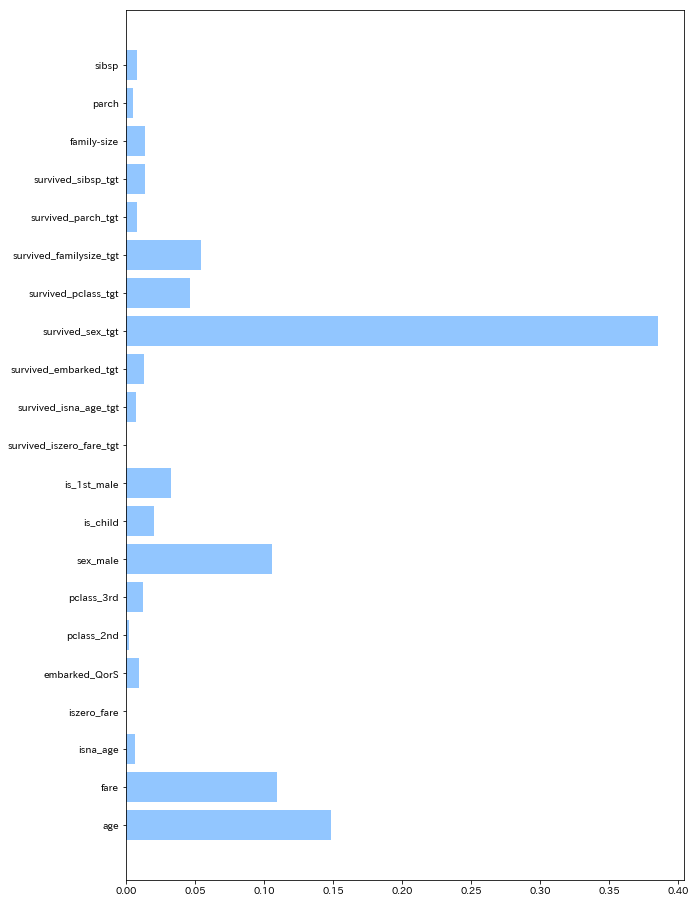

In [30]:
plt.figure(figsize=(10,16))
plt.barh(y=train_X.columns ,width=model.feature_importances_)

In [31]:
X = train_X.copy() 
y = train_y.copy()
res = list()

for train_index, test_index in kf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    rf = RandomForestClassifier(**params)
    rf.fit(X_train, y_train)
    p = rf.predict_proba(X_test)[:,1]
    proba = y_test.copy().to_frame()
    proba["p"] = p
    res.append(proba)

C:\Users\keisu\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



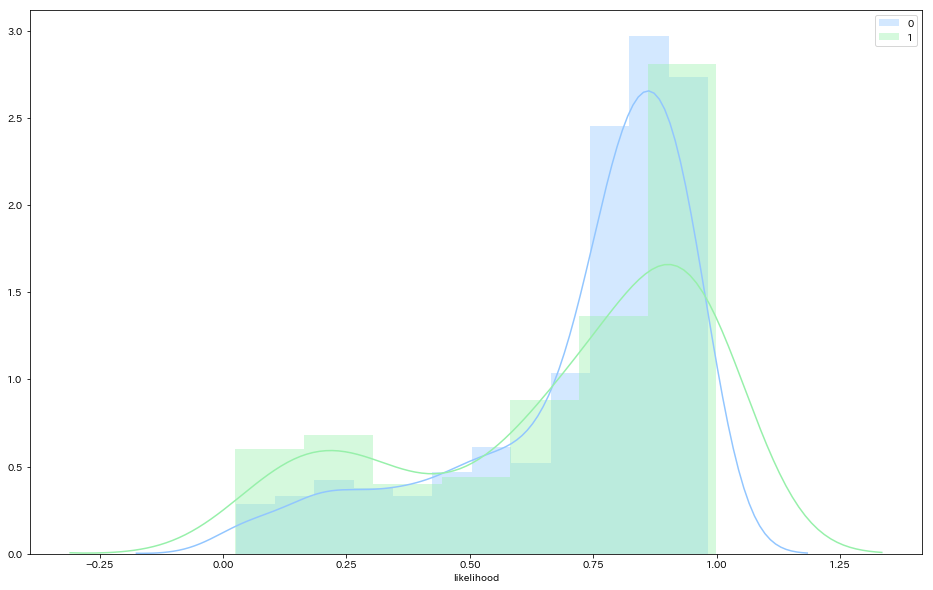

In [32]:
likelihood = pd.concat(res)
likelihood["likelihood"] = (likelihood.p**likelihood.survived)*((1-likelihood.p)**(1-likelihood.survived))

plt.figure(figsize=(16,10))
for i in range(2):
    subs = likelihood[likelihood.survived==i]
    sns.distplot(subs.likelihood, label=str(i))
plt.legend()

In [33]:
error_id = likelihood[likelihood.likelihood <= 0.4].index

In [34]:
train_X[train_X.index.isin(error_id)].describe()

,age,fare,isna_age,iszero_fare,embarked_QorS,pclass_2nd,pclass_3rd,sex_male,is_child,is_1st_male,...,survived_isna_age_tgt,survived_embarked_tgt,survived_sex_tgt,survived_pclass_tgt,survived_familysize_tgt,survived_parch_tgt,survived_sibsp_tgt,family-size,parch,sibsp
count,74.000000,74.000000,74.000000,74.0,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,...,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000
mean,-0.161392,0.105129,0.148649,0.0,0.756757,0.135135,0.581081,0.662162,0.081081,0.243243,...,0.407909,0.417668,0.394932,0.404462,0.415398,0.399158,0.403464,1.027027,0.472973,0.540541
std,1.140508,0.884194,0.358170,0.0,0.431969,0.344201,0.496750,0.476201,0.274823,0.431969,...,0.047873,0.102300,0.273792,0.188295,0.160775,0.094878,0.132727,1.525787,0.879336,0.953568
min,-4.219808,-0.914231,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.294118,0.354740,0.200692,0.258333,0.142857,0.200000,0.000000,0.000000,0.000000,0.000000
25%,-0.219849,-0.781964,0.000000,0.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.427778,0.354740,0.200692,0.258333,0.305344,0.357576,0.351171,0.000000,0.000000,0.000000
50%,0.196479,-0.051784,0.000000,0.0,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,...,0.427778,0.354740,0.200692,0.258333,0.305344,0.357576,0.351171,0.000000,0.000000,0.000000
75%,0.332548,0.511381,0.000000,0.0,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,...,0.427778,0.410256,0.775641,0.685185,0.620253,0.410823,0.576577,1.000000,1.000000,1.000000
max,1.790708,2.473248,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.427778,0.594937,0.775641,0.685185,0.666667,0.642857,0.576577,6.000000,4.000000,4.000000


In [35]:
train_X[~train_X.index.isin(error_id)].describe()

,age,fare,isna_age,iszero_fare,embarked_QorS,pclass_2nd,pclass_3rd,sex_male,is_child,is_1st_male,...,survived_isna_age_tgt,survived_embarked_tgt,survived_sex_tgt,survived_pclass_tgt,survived_familysize_tgt,survived_parch_tgt,survived_sibsp_tgt,family-size,parch,sibsp
count,371.000000,371.000000,371.000000,371.000000,371.000000,371.000000,371.000000,371.000000,371.000000,371.000000,...,371.000000,371.000000,371.000000,371.000000,371.000000,371.000000,371.000000,371.000000,371.000000,371.000000
mean,0.003697,0.048496,0.199461,0.010782,0.835580,0.234501,0.530997,0.646900,0.053908,0.099730,...,0.401118,0.399171,0.403706,0.401805,0.399624,0.402863,0.402004,0.967655,0.415094,0.477089
std,0.984102,1.004124,0.400135,0.103413,0.371157,0.424259,0.499712,0.478579,0.226142,0.300045,...,0.053482,0.088358,0.275158,0.173916,0.164523,0.099683,0.124374,1.776431,0.805514,0.883108
min,-4.512634,-3.056861,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.294118,0.354740,0.200692,0.258333,0.000000,0.200000,0.000000,0.000000,0.000000,0.000000
25%,-0.253699,-0.801473,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.427778,0.354740,0.200692,0.258333,0.305344,0.357576,0.351171,0.000000,0.000000,0.000000
50%,0.215183,-0.228477,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,...,0.427778,0.354740,0.200692,0.258333,0.305344,0.357576,0.351171,0.000000,0.000000,0.000000
75%,0.518338,0.617852,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,...,0.427778,0.410256,0.775641,0.443299,0.596154,0.357576,0.571429,1.000000,1.000000,1.000000
max,1.576729,3.383393,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.427778,0.594937,0.775641,0.685185,0.666667,0.642857,0.576577,10.000000,4.000000,4.000000


# modeling --LightGBM--

In [36]:
from sklearn.metrics import roc_auc_score
import lightgbm as lgb

In [37]:
def objective(traX, traY, tesX, tesY, trial):
    train = lgb.Dataset(traX, traY)
    valid = lgb.Dataset(tesX, tesY)
    params = {
        'boosting_type': 'goss',
        'objective': 'binary',
        'metric': 'auc',
        'num_leaves': trial.suggest_int("num_leaves", 10, 500),
        'learning_rate': trial.suggest_uniform("learning_rate", 0.01, 1),
        'min_data_in_leaf': trial.suggest_int("min_data_in_leaf", 1, 100),
        'feature_fraction': trial.suggest_uniform("feature_fraction", 0.2, 0.4),
        'bagging_fraction': trial.suggest_uniform("bagging_fraction", 0.2, 0.8),
        'verbose' : 0
    }
    clf = lgb.train(params=params, num_boost_round=2**10, early_stopping_rounds=2**4,
                    train_set=train, valid_sets=valid,
                    verbose_eval=False
                    )
    score = roc_auc_score(y_true=tesY, y_score=clf.predict(tesX))
    return score

In [38]:
optuna.logging.disable_default_handler()
# optuna.logging.enable_default_handler()

In [39]:
from functools import partial

In [40]:
kf = StratifiedKFold(n_splits=3, shuffle=True)

models = list()
X = train_X.copy() 
y = train_y.copy()

i = 1

for train_index, test_index in kf.split(X, y):
    print("===========================", " model ", i, "===========================")
    traX, tesX = X.iloc[train_index], X.iloc[test_index]
    traY, tesY = y.iloc[train_index], y.iloc[test_index]
    score = 0.5
    while score <= 0.8:
        o = partial(objective, traX, traY, tesX, tesY)
        study = optuna.create_study(direction='maximize')
        study.optimize(o, n_trials=2**10)
        param = study.best_params
        score = study.best_value
        
    print(score)
    param['boosting_type'] = 'goss',
    param['objective'] = 'binary',
    param['metric'] = 'auc',
    train = lgb.Dataset(traX, traY)
    valid = lgb.Dataset(tesX, tesY)
    model = lgb.train(params=param, num_boost_round=2**10, early_stopping_rounds=2**4,
                      train_set=train, valid_sets=valid, verbose_eval=False)
    models.append(model)
    i += 1

===========================  model  1 ===========================
0.8916666666666666
===========================  model  2 ===========================
0.9039325842696628
===========================  model  3 ===========================
0.932010785824345


In [41]:
pred = 0
auc = 0

for model in models:
    s = model.best_score["valid_0"]["auc"]
    p = model.predict(test_X)
    pred += p*s
    auc += s
pred = pred / auc

In [42]:
submit = test_X.copy()[[]]
submit["pred"] = pred
submit.to_csv("../data/submit/"+"lgb.tsv", sep="\t", header=None)
# res: auc = 0.8684342